### Project Intro

Project Explanaiton here

## 1. Setting

In [1]:
# Installation 
!pip install kaggle
!pip install pyspark
!pip install feedparser
!pip install torch
!pip install sentence-transformers
!pip install numpy
!pip install rake-nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317145 sha256=b98337184353a9355f3aa1a57e2ca89c7881cf197bd8f8e86f4c36104360c5dc
  Stored in directory: /root/.cache/pip/wheels/9f/34/a4/159aa12d0a510d5ff7c8f0220abbea42e5d81ecf588c4fd884
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6065 sha256=d06b51d232eb2bb2ef4659371d17556802a38ac9d843284ac1ca00988ce22654
  Stored in

In [137]:
# libraries
import json
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import * 
import requests
from lxml import etree
import nltk
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt 
from rake_nltk import Rake
import csv
import seaborn as sns

#import libraries for knowledge graph
import re
import bs4
import requests
import spacy
from spacy import displacy
from spacy.matcher import Matcher 
from spacy.tokens import Span 
import networkx as nx
from tqdm import tqdm
%matplotlib inline

In [3]:
# Run this cell to mount your drive (you will be prompted to sign in)
from google.colab import drive
drive.mount('/content/drive')

!mkdir ~/.kaggle

Mounted at /content/drive


In [4]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

In [5]:
# start sparkSession
spark = SparkSession.builder.appName("MyApp").getOrCreate()

## 2. Data Wrangling


### 1) Arxiv Data


#### a. Import Data

**Arxiv Data**
* id: ArXiv ID (can be used to access the paper, see below)
* submitter: Who submitted the paper
* authors: Authors of the paper
* title: Title of the paper
* comments: Additional info, such as number of pages and figures
* journal-ref: Information about the journal the paper was published in
* doi: [https://www.doi.org](Digital Object Identifier)
* abstract: The abstract of the paper
* categories: Categories / tags in the ArXiv system
* versions: A version history



In [6]:
!kaggle datasets download -d Cornell-University/arxiv
!unzip /content/arxiv.zip

 99% 1.12G/1.14G [00:07<00:00, 200MB/s]
100% 1.14G/1.14G [00:07<00:00, 168MB/s]
Archive:  /content/arxiv.zip
  inflating: arxiv-metadata-oai-snapshot.json  


In [7]:
arxiv_df = spark.read.json("arxiv-metadata-oai-snapshot.json", multiLine = False, primitivesAsString = True)

In [8]:
arxiv_df.show()

+--------------------+--------------------+--------------------+-----------------+--------------------+--------------------+---------+--------------------+--------------------+--------------------+------------------+--------------------+-----------+--------------------+
|            abstract|             authors|      authors_parsed|       categories|            comments|                 doi|       id|         journal-ref|             license|           report-no|         submitter|               title|update_date|            versions|
+--------------------+--------------------+--------------------+-----------------+--------------------+--------------------+---------+--------------------+--------------------+--------------------+------------------+--------------------+-----------+--------------------+
|  A fully differe...|C. Bal\'azs, E. L...|[[Balázs, C., ], ...|           hep-ph|37 pages, 15 figu...|10.1103/PhysRevD....|0704.0001|Phys.Rev.D76:0130...|                null|    ANL-HEP

#### b. Authors Analysis

- authors article count (counted by all authors based, merged by first author)
- collaboration T/F

In [9]:
arxiv_df = arxiv_df.withColumn('first_author', regexp_replace(concat_ws(" ", element_at("authors_parsed", 1)), ",", ""))
arxiv_df = arxiv_df.withColumn("first_author", trim('first_author'))


In [10]:
author_flattened_ver = arxiv_df.selectExpr("*", "explode(authors_parsed) as authors_flat")
count_df = author_flattened_ver.withColumn('authors_join', regexp_replace(concat_ws(" ", "authors_flat"), ",", ""))
count_df = count_df.withColumn("authors_join", trim(count_df.authors_join))
count_df = count_df.groupBy("authors_join").agg(count('*').alias('article_counts_1st'))
count_df = count_df.orderBy('article_counts_1st', ascending= False)
count_df.show()

+-------------------+------------------+
|       authors_join|article_counts_1st|
+-------------------+------------------+
|           Zhang Y.|              2196|
|            Wang Y.|              1540|
|            Wang J.|              1443|
|              Li Y.|              1366|
|           Liu Yang|              1265|
|           Zhang L.|              1249|
|           Wang Wei|              1206|
|             Liu X.|              1196|
|             Gao Y.|              1185|
|  CMS Collaboration|              1175|
|  Taniguchi Takashi|              1171|
|            Wang Z.|              1147|
|     Watanabe Kenji|              1132|
|ATLAS Collaboration|              1076|
|            Yang Z.|              1042|
|             Sun L.|              1017|
|          Zhang Lei|               987|
|              Xu Z.|               945|
|          Zhang Wei|               942|
|        Krokovny P.|               941|
+-------------------+------------------+
only showing top

In [11]:
count_df.filter(col('authors_join') == 'Zhang Y.').select('article_counts_1st').show()

+------------------+
|article_counts_1st|
+------------------+
|              2196|
+------------------+



In [ ]:
arxiv_df.filter(col('first_author')=='Zhang Y.').show(5)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------+--------------------+--------------------+---------+--------------------+--------------------+-----------+--------------------+------------+
|            abstract|             authors|      authors_parsed|          categories|            comments|                 doi|       id|         journal-ref|             license|report-no|           submitter|               title|update_date|            versions|first_author|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------+--------------------+--------------------+---------+--------------------+--------------------+-----------+--------------------+------------+
|  We investigate ...|Y. Zhang, G. Liu,...|[[Zhang, Y., ], [...|cond-mat.mes-hall...|                null|                null|0708.3118|                null|        

In [13]:
arxiv_df = arxiv_df.join(count_df, arxiv_df.first_author == count_df.authors_join, "left")
arxiv_df.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------+--------------------+--------------------+-------------------+--------------------+--------------------+-----------+--------------------+--------------------+--------------------+------------------+
|            abstract|             authors|      authors_parsed|          categories|            comments|                 doi|              id|         journal-ref|             license|          report-no|           submitter|               title|update_date|            versions|        first_author|        authors_join|article_counts_1st|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------+--------------------+--------------------+-------------------+--------------------+--------------------+-----------+--------------------+--------------------+------------

In [14]:
arxiv_df = arxiv_df.withColumn('collab_tf', when(lower(col('authors')).contains('collaboration'), 1).otherwise(0))

In [ ]:
arxiv_df.groupBy('collab_tf').agg(count('*').alias('count')).show()

+---------+-------+
|collab_tf|  count|
+---------+-------+
|        1|  24894|
|        0|2213986|
+---------+-------+



#### c. Category Name Mapping

**category name mapping** 

- parsing from arxiv official taxonomy web page "https://arxiv.org/category_taxonomy"

In [12]:
url = "https://arxiv.org/category_taxonomy"

response = requests.get(url)
# print(response)
categories = pd.DataFrame(columns=['cat_id', 'main_category','sub_category'])
if response.status_code == 200:
    parser = etree.HTMLParser()
    tree = etree.fromstring(response.content, parser=parser)

    for x, y in zip(tree.xpath("//*[@id='category_taxonomy_list']//h4/text()"), tree.xpath("//*[@id='category_taxonomy_list']//h4/span/text()")):
      cat_id = x.strip()
      sub_cat = y.strip("()").strip()
      big_cat = cat_id.split(".")[0]
      categories = pd.concat([categories, pd.DataFrame({'cat_id': [cat_id], 'main_category' : [big_cat], 'sub_category': [sub_cat]})], ignore_index=True)
    
    big_category = tree.xpath("//*[@id='category_taxonomy_list']/h2/text()") + tree.xpath("//*[@id='category_taxonomy_list']//h3/text()")
categories

,cat_id,main_category,sub_category
0,cs.AI,cs,Artificial Intelligence
1,cs.AR,cs,Hardware Architecture
2,cs.CC,cs,Computational Complexity
3,cs.CE,cs,"Computational Engineering, Finance, and Science"
4,cs.CG,cs,Computational Geometry
...,...,...,...
150,stat.CO,stat,Computation
151,stat.ME,stat,Methodology
152,stat.ML,stat,Machine Learning
153,stat.OT,stat,Other Statistics


In [15]:
cat_map_dict = {}
cat_map_dict['cs'] = 'Computer Science'
cat_map_dict['econ'] = 'Economics'
cat_map_dict['eess'] = 'Electrical Engineering and Systems Science'
cat_map_dict['math'] =  'Mathematics'
cat_map_dict['astro-ph'] = 'Astrophysics'
cat_map_dict['cond-mat'] = 'Condensed Matter'
cat_map_dict['gr-qc'] = 'General Relativity and Quantum Cosmology'
cat_map_dict['hep-ex'] =  'High Energy Physics - Experiment'
cat_map_dict['hep-lat'] = 'High Energy Physics - Lattice'
cat_map_dict['hep-ph'] =  'High Energy Physics - Phenomenology'
cat_map_dict['hep-th'] = 'High Energy Physics - Theory'
cat_map_dict['math-ph'] = 'Mathematical Physics'
cat_map_dict['nlin'] = 'Nonlinear Sciences'
cat_map_dict['nucl-ex'] = 'Nuclear Experiment'
cat_map_dict['nucl-th'] =  'Nuclear Theory'
cat_map_dict['physics'] = 'Physics'
cat_map_dict['quant-ph'] = 'Quantum Physics'
cat_map_dict['q-bio'] = 'Quantitative Biology'
cat_map_dict['q-fin'] = 'Quantitative Finance'
cat_map_dict['stat'] = 'Statistics'

In [16]:
categories['main_category'].unique()

array(['cs', 'econ', 'eess', 'math', 'astro-ph', 'cond-mat', 'gr-qc',
       'hep-ex', 'hep-lat', 'hep-ph', 'hep-th', 'math-ph', 'nlin',
       'nucl-ex', 'nucl-th', 'physics', 'quant-ph', 'q-bio', 'q-fin',
       'stat'], dtype=object)

In [17]:
big_category

['Computer Science',
 'Economics',
 'Electrical Engineering and Systems Science',
 'Mathematics',
 'Physics',
 'Quantitative Biology',
 'Quantitative Finance',
 'Statistics',
 'Astrophysics',
 'Condensed Matter',
 'General Relativity and Quantum Cosmology',
 'High Energy Physics - Experiment',
 'High Energy Physics - Lattice',
 'High Energy Physics - Phenomenology',
 'High Energy Physics - Theory',
 'Mathematical Physics',
 'Nonlinear Sciences',
 'Nuclear Experiment',
 'Nuclear Theory',
 'Physics',
 'Quantum Physics']

In [18]:
big_category = ['Computer Science',
 'Economics',
 'Electrical Engineering and Systems Science',
 'Mathematics',
 'Physics',
 'Quantitative Biology',
 'Quantitative Finance',
 'Statistics',
 'Astrophysics',
 'Condensed Matter',
 'General Relativity and Quantum Cosmology',
 'High Energy Physics - Experiment',
 'High Energy Physics - Lattice',
 'High Energy Physics - Phenomenology',
 'High Energy Physics - Theory',
 'Mathematical Physics',
 'Nonlinear Sciences',
 'Nuclear Experiment',
 'Nuclear Theory',
 'Physics',
 'Quantum Physics']

In [21]:
categories['main_category'] = categories['main_category'].apply(lambda x : cat_map_dict[x])
categories['main_category']

0      Computer Science
1      Computer Science
2      Computer Science
3      Computer Science
4      Computer Science
             ...       
150          Statistics
151          Statistics
152          Statistics
153          Statistics
154          Statistics
Name: main_category, Length: 155, dtype: object

In [22]:
categories.set_index('cat_id', inplace = True)

In [23]:
categories_dict = categories.to_dict(orient='index')

In [27]:
categories

,main_category,sub_category
cat_id,,
cs.AI,Computer Science,Artificial Intelligence
cs.AR,Computer Science,Hardware Architecture
cs.CC,Computer Science,Computational Complexity
cs.CE,Computer Science,"Computational Engineering, Finance, and Science"
cs.CG,Computer Science,Computational Geometry
...,...,...
stat.CO,Statistics,Computation
stat.ME,Statistics,Methodology
stat.ML,Statistics,Machine Learning


In [28]:
# export as csv
# read this after this if category scraping is blocked, 
categories.to_csv('/content/drive/MyDrive/categories_dict.csv')

In [35]:
# read csv and convert it to dict
categories = pd.read_csv('/content/drive/MyDrive/categories_dict.csv')
categories.set_index('cat_id', inplace = True)
categories_dict = categories.to_dict(orient='index')

In [36]:
# make categories list first
arxiv_df = arxiv_df.withColumn('categories_parsed', split(arxiv_df['categories'], ' '))
arxiv_df.select('categories_parsed').show(5)

+------------------+
| categories_parsed|
+------------------+
|          [hep-ph]|
|  [math.CO, cs.CG]|
|  [physics.gen-ph]|
|         [math.CO]|
|[math.CA, math.FA]|
+------------------+
only showing top 5 rows



In [37]:
def cat_main_name(list_x):
  out_list = []
  for a in list_x:
    try:
      if categories_dict[a]['main_category'] not in out_list:
        out_list.append(categories_dict[a]['main_category'])
    except:
      out_list.append(a)
  return out_list

def cat_sub_name(list_x):
  out_list = []
  for a in list_x:
    try:
      if categories_dict[a]['sub_category'] not in out_list:
        out_list.append(categories_dict[a]['sub_category'])
    except:
      out_list.append(a)
  return out_list

In [38]:
udf_cat_main_name = udf(cat_main_name, ArrayType(StringType()))
udf_cat_sub_name = udf(cat_sub_name, ArrayType(StringType()))

arxiv_df = arxiv_df.withColumn('cat_main_name', udf_cat_main_name('categories_parsed'))
arxiv_df = arxiv_df.withColumn('cat_sub_name', udf_cat_sub_name('categories_parsed'))

In [ ]:
arxiv_df.select('cat_main_name').show(5)

+--------------------+
|       cat_main_name|
+--------------------+
|[High Energy Phys...|
|[Mathematics, Com...|
|           [Physics]|
|       [Mathematics]|
|       [Mathematics]|
+--------------------+
only showing top 5 rows



In [ ]:
arxiv_df.select('cat_sub_name').show(5)

+--------------------+
|        cat_sub_name|
+--------------------+
|[High Energy Phys...|
|[Combinatorics, C...|
|   [General Physics]|
|     [Combinatorics]|
|[Classical Analys...|
+--------------------+
only showing top 5 rows



#### d. Title & Abstract Key-Word Extraction
* by NLP

In [42]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

stopwords = set(nltk.corpus.stopwords.words('english'))

def tokenize_content(content):
  tokens = nltk.word_tokenize(content)
  words = [
    token.lower() 
    for token in tokens 
      if token.isalpha() and token.lower() not in stopwords
  ]
  return words

def sent_tokenize_content(content):
  tokens = nltk.sent_tokenize(content)
  return tokens

tokenize_content_udf = udf(tokenize_content, ArrayType(StringType()))
sent_tokenize_content_udf = udf(sent_tokenize_content, ArrayType(StringType()))

def get_sentence_ne(sentence):
  chunked = nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(sentence)))
  return [ 
      " ".join(w for w, t in elt) 
      for elt in chunked if isinstance(elt, nltk.Tree) 
  ]

def get_ne(content):
  sentences = nltk.sent_tokenize(content)
  sentence_nes = [get_sentence_ne(sentence) for sentence in sentences]
  return [ne for nes in sentence_nes for ne in nes]

get_ne_udf = udf(get_ne, ArrayType(StringType()))

def get_rake(sentence):
  r = Rake()
  r.extract_keywords_from_text(sentence)
  keywords = r.get_ranked_phrases()
  return keywords

get_rake_udf = udf(get_rake, ArrayType(StringType()))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [43]:
arxiv_df = arxiv_df.withColumn("abstract_tokens", tokenize_content_udf("abstract"))
arxiv_df = arxiv_df.withColumn("abstract_ne", get_ne_udf("abstract"))
arxiv_df = arxiv_df.withColumn("abstract_rake_tokens", tokenize_content_udf("abstract"))
arxiv_df.select(['abstract','abstract_tokens', 'abstract_ne', 'abstract_rake_tokens']).show(5)

+--------------------+--------------------+--------------------+--------------------+
|            abstract|     abstract_tokens|         abstract_ne|abstract_rake_tokens|
+--------------------+--------------------+--------------------+--------------------+
|  A fully differe...|[fully, different...|[Good, Fermilab T...|[fully, different...|
|  We describe a n...|[describe, new, a...|[Lee, Streinu, Ga...|[describe, new, a...|
|  The evolution o...|[evolution, syste...|[Division, Partic...|[evolution, syste...|
|  We show that a ...|[show, determinan...|                  []|[show, determinan...|
|  In this paper w...|[paper, show, com...|             [Hardy]|[paper, show, com...|
+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [44]:
arxiv_df = arxiv_df.withColumn("title_tokens", tokenize_content_udf("title"))
arxiv_df = arxiv_df.withColumn("title_ne", get_ne_udf("title"))
arxiv_df = arxiv_df.withColumn("title_rake_tokens", tokenize_content_udf("title"))
arxiv_df.select(['title','title_tokens','title_ne', 'title_rake_tokens']).show(5)

+--------------------+--------------------+--------------------+--------------------+
|               title|        title_tokens|            title_ne|   title_rake_tokens|
+--------------------+--------------------+--------------------+--------------------+
|Calculation of pr...|[calculation, pro...|[Calculation, Tev...|[calculation, pro...|
|Sparsity-certifyi...|[graph, decomposi...|[Graph Decomposit...|[graph, decomposi...|
|The evolution of ...|[evolution, syste...|                  []|[evolution, syste...|
|A determinant of ...|[determinant, sti...|                  []|[determinant, sti...|
|From dyadic $\Lam...|            [dyadic]|                  []|            [dyadic]|
+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows



####e. Word Cloud or top tokens comparison

In [132]:
arxiv_small_df = arxiv_df.limit(1000).select(["abstract_tokens", "title_tokens", "abstract_ne","title_ne", "abstract_rake_tokens", "title_rake_tokens", "cat_main_name", "cat_sub_name", "first_author", "collab_tf"])
arxiv_small_pd = arxiv_small_df.toPandas()

In [129]:
# drawing function of wordcloud
# TODO : show wc horizontally
def draw_wc(token_counts, title, ax):
  wordcloud = WordCloud(width = 640, height = 640,
                background_color ='white',
                min_font_size = 8).fit_words(token_counts)
 
  # plot the WordCloud image                      
  # ax.figure(figsize = (4, 4), facecolor = None)
  ax.imshow(wordcloud)
  ax.axis("off")
  ax.set_title(title)

def plot_top_10_tokens(token_counts, title, ax):
  top_tokens = sorted(token_counts.items(), key=lambda x: x[1], reverse=True)[:20]
  sns.barplot(x=[x[0] for x in top_tokens], y=[x[1] for x in top_tokens], ax=ax)
  ax.set_title(title)
  ax.set_ylabel('Counts')
  ax.tick_params(axis='x', rotation=45)
  plt.subplots_adjust(hspace = 0.7)

abstract tokens 

In [49]:
abstract_tokens_total = [token for tokens in list(arxiv_small_pd["abstract_tokens"]) for token in tokens]
abstract_token_counts = Counter(abstract_tokens_total)

abstract_nes_total = [token for tokens in list(arxiv_small_pd["abstract_ne"]) for token in tokens]
abstract_nes_counts = Counter(abstract_nes_total)

abstract_rakes_total = [token for tokens in list(arxiv_small_pd["abstract_rake_tokens"]) for token in tokens]
abstract_rakes_counts = Counter(abstract_rakes_total)

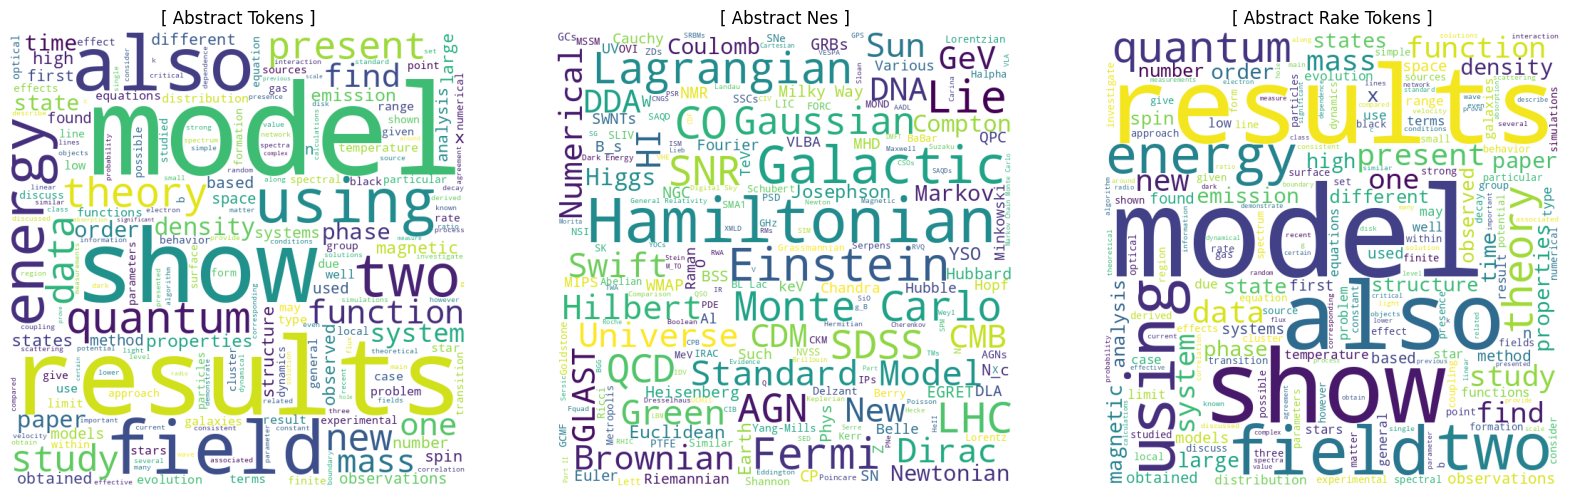

In [116]:
fig, axs = plt.subplots(1, 3, figsize=(20, 20))

draw_wc(abstract_token_counts, "[ Abstract Tokens ]", axs[0])
draw_wc(abstract_nes_counts, "[ Abstract Nes ]", axs[1])
draw_wc(abstract_rakes_counts, "[ Abstract Rake Tokens ]", axs[2])

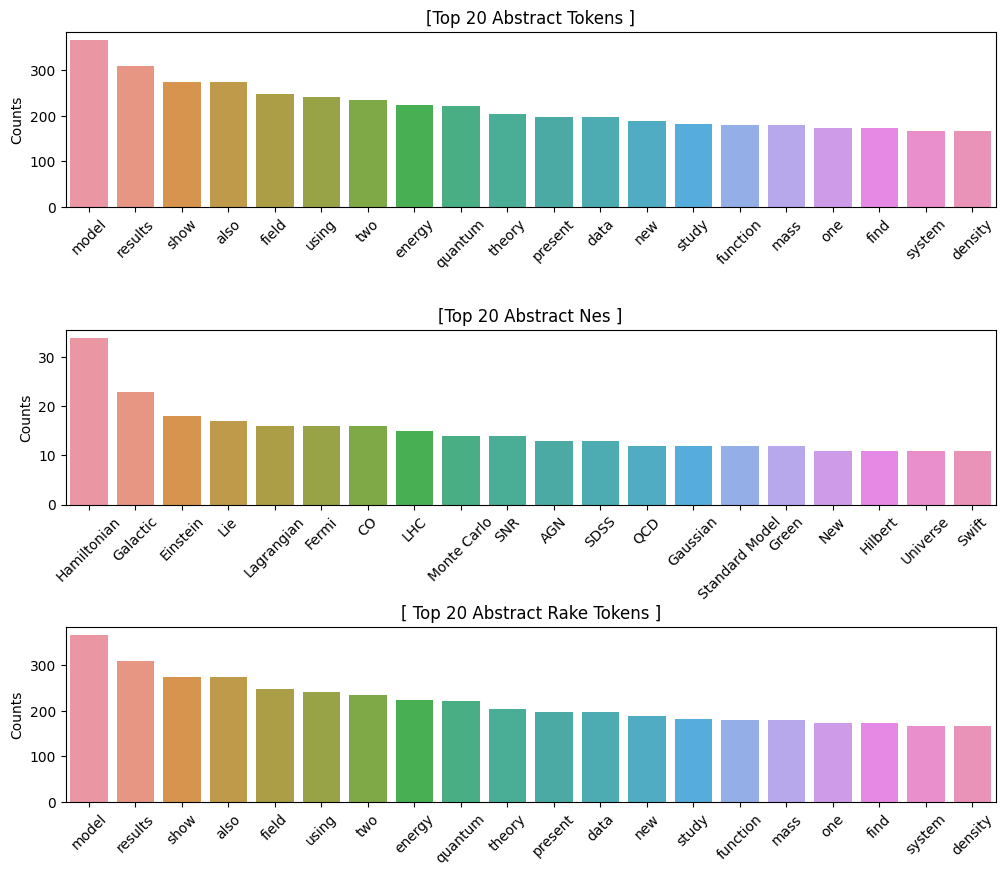

In [121]:
fig, axs = plt.subplots(3, 1, figsize=(12, 10))

plot_top_10_tokens(abstract_token_counts, "[Top 20 Abstract Tokens ]", axs[0])
plot_top_10_tokens(abstract_nes_counts, "[Top 20 Abstract Nes ]", axs[1])
plot_top_10_tokens(abstract_rakes_counts, "[ Top 20 Abstract Rake Tokens ]", axs[2])


Title Tokens

In [126]:
title_tokens_total = [token for tokens in list(arxiv_small_pd["title_tokens"]) for token in tokens]
title_token_counts = Counter(title_tokens_total)

title_nes_total = [token for tokens in list(arxiv_small_pd["title_ne"]) for token in tokens]
title_nes_counts = Counter(title_nes_total)

title_rakes_total = [token for tokens in list(arxiv_small_pd["title_rake_tokens"]) for token in tokens]
title_rakes_counts = Counter(title_rakes_total)

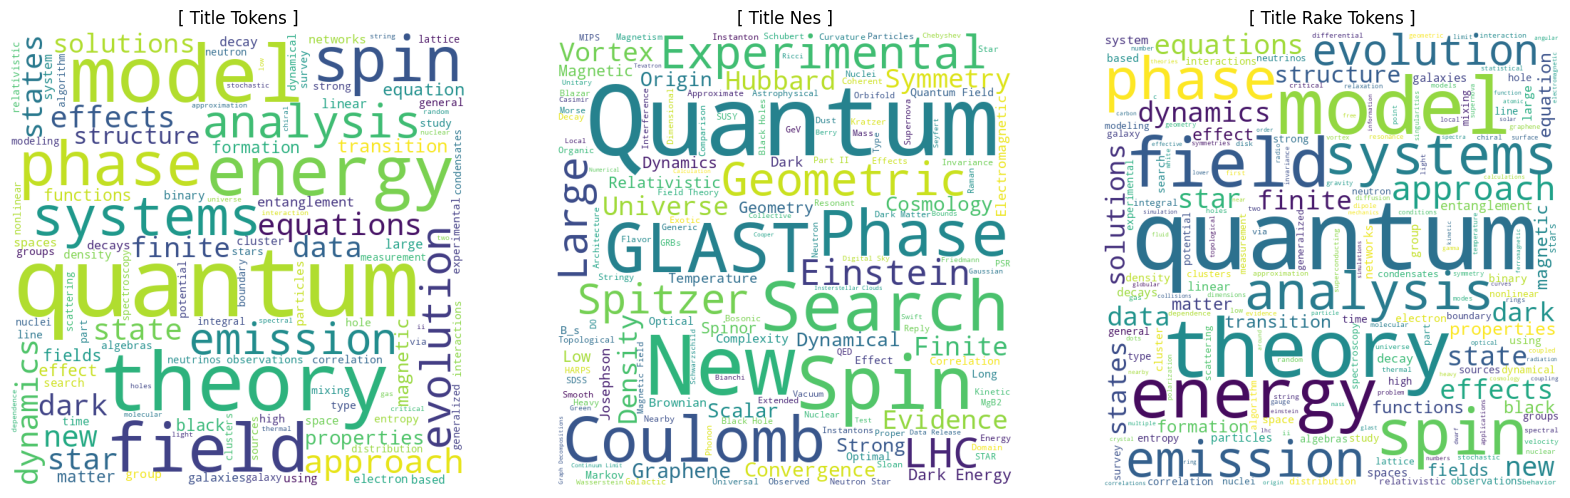

In [115]:
fig, axs = plt.subplots(1, 3, figsize=(20, 20))

draw_wc(title_token_counts, "[ Title Tokens ]", axs[0])
draw_wc(title_nes_counts, "[ Title Nes ]", axs[1])
draw_wc(title_rakes_counts, "[ Title Rake Tokens ]", axs[2])

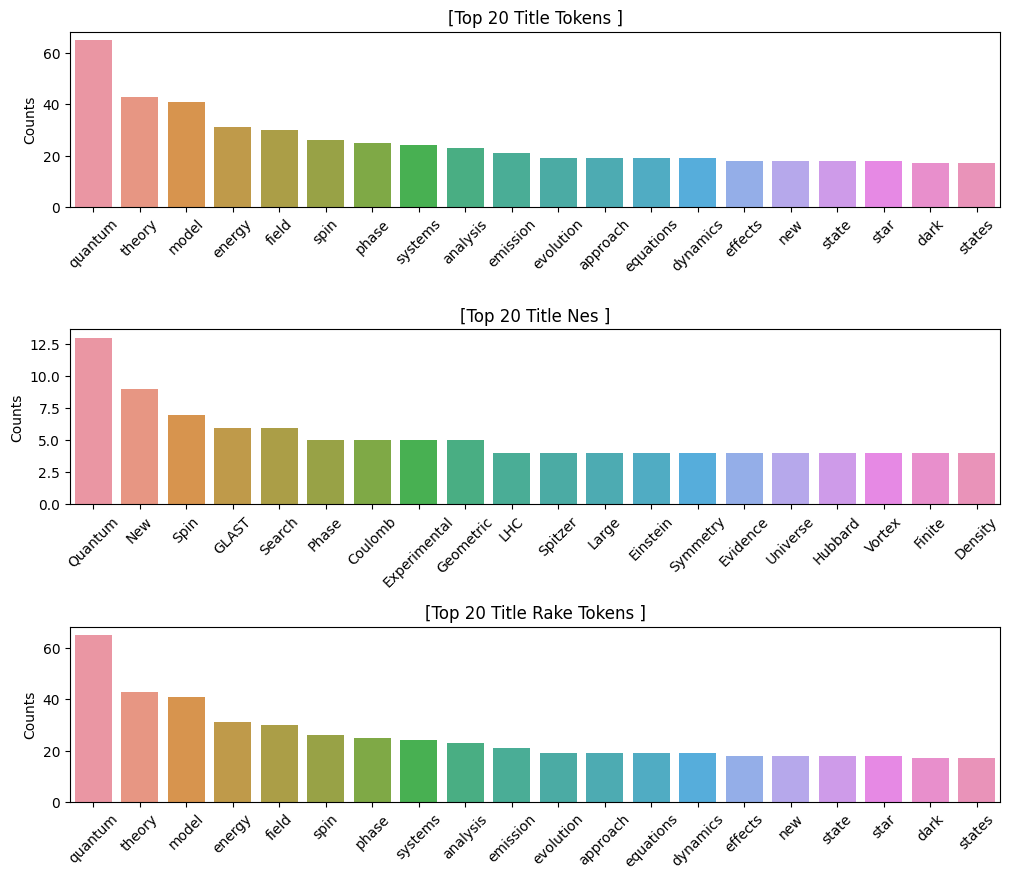

In [130]:
fig, axs = plt.subplots(3, 1, figsize=(12, 10))

plot_top_10_tokens(title_token_counts, "[Top 20 Title Tokens ]", axs[0])
plot_top_10_tokens(title_nes_counts, "[Top 20 Title Nes ]", axs[1])
plot_top_10_tokens(title_rakes_counts, "[Top 20 Title Rake Tokens ]", axs[2])

The word cloud of top tokens and rake tokens are almost same.

Extra plotting if it needs

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20, 20))

draw_wc(title_token_counts, "[ Title Tokens ]", axs[0])
draw_wc(title_nes_counts, "[ Title Nes ]", axs[1])
draw_wc(title_rakes_counts, "[ Title Rake Tokens ]", axs[2])

In [ ]:
# TODO when the parsing possible
# main_caegories | tokens & main_cateogires | tokens_counts
for 
abstract_tokens_cat = [token for tokens in list(arxiv_small_pd["abstract_tokens"]) for token in tokens]
for tokens
abstract_token_counts = Counter(abstract_tokens_total)

# TODO when the parsing possible
# sub_caegories | tokens & sub_cateogires | tokens_counts


# select top 5 first_authors
# first_autors | tokens & first_authors | tokens_counts
# abstract_tokens_author = [token for tokens in list(arxiv_small_pd["abstract_tokens"]) for token in tokens]
# abstract_token_counts = Counter(abstract_tokens_total)

# collab_tf | tokens & collab_tf | tokens_counts
# abstract_tokens_collab_0 = [token for tokens in list(arxiv_small_pd[arxiv_small_pd["collab_tf"] == 0]["abstract_tokens"]) for token in tokens]
# abstract_tokens_collab_1 = [token for tokens in list(arxiv_small_pd[arxiv_small_pd["collab_tf"] == 1]["abstract_tokens"]) for token in tokens]
# abstract_token_counts_collab_0 = Counter(abstract_tokens_collab_0)
# abstract_token_counts_collab_1 = Counter(abstract_tokens_collab_1)

# abstract_nes_collab_0 = [token for tokens in list(arxiv_small_pd[arxiv_small_pd["collab_tf"] == 0]["title_ne"]) for token in tokens]
# abstract_nes_collab_1 = [token for tokens in list(arxiv_small_pd[arxiv_small_pd["collab_tf"] == 1]["title_ne"]) for token in tokens]
# abstract_nes_counts_collab_0 = Counter(abstract_nes_collab_0)
# abstract_nes_counts_collab_1 = Counter(abstract_nes_collab_1)

##### f. BFS

In [164]:
arxiv_another_df = arxiv_df.select(["abstract_tokens", "title_tokens", "abstract_ne","title_ne", "abstract_rake_tokens", "title_rake_tokens", "cat_main_name", "cat_sub_name", "first_author", "collab_tf"]).exceptAll(arxiv_small_df).limit(1000).select(["abstract_tokens", "title_tokens", "abstract_ne","title_ne", "abstract_rake_tokens", "title_rake_tokens", "cat_main_name", "cat_sub_name", "first_author", "collab_tf"])

In [150]:
# Define BFS algorithm
def bfs(graph, start, end):
    queue = [(start, [start])]
    while queue:
        (node, path) = queue.pop(0)
        for next_node in graph[node]:
            if next_node not in path:
                if next_node == end:
                    return path + [next_node]
                else:
                    queue.append((next_node, path + [next_node]))

def build_graph(df1, df2, tokens):
  graph = {}
  # Add nodes to graph
  for _, row in df1.iterrows():
      if row[tokens] in tokens:
          graph[row[tokens]] = []
          
  for _, row in df2.iterrows():
      if row[tokens] in tokens:
          graph[row[tokens]] = []

  # Add edges to graph
  for _, row in df1.iterrows():
      if row[tokens] in tokens:
          for _, row2 in df2.iterrows():
              if row2[tokens] == row[tokens]:
                  graph[row[tokens]].append(row2[tokens])
  return graph

def draw_graph(grap, title):
  G = nx.Graph(graph)
  pos = nx.spring_layout(G)
  nx.draw_networkx_nodes(G, pos, node_color='r', node_size=500)
  nx.draw_networkx_edges(G, pos, edge_color='b', width=2)
  nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')
  plt.axis('off')
  plt.title(title)
  plt.show()



In [ ]:
# Find intersection of tokens
tokens =  arxiv_small_df.select("title_tokens").intersect(arxiv_another_df.select("title_tokens")).select(explode("title_tokens").alias("token")).groupBy("token").count().filter("count >= 2").select("token").rdd.flatMap(lambda x: x).collect()

graph = build_graph(arxiv_small_df, arxiv_another_df, 'title_tokens')
draw_graph(graph, "[ Title Tokens Join ]")
# bfs(graph, 'banana', 'elderberry')

####f. Knowledge Graph

Knowledge graph for abstract sentences

In [136]:
nlp = spacy.load('en_core_web_sm')
pd.set_option('display.max_colwidth', 200)


In [ ]:
# example of nlp
doc = nlp("the drawdown process is governed by astm standard d823")

for tok in doc:
  print(tok.text, "...", tok.dep_)

the ... det
drawdown ... amod
process ... nsubjpass
is ... auxpass
governed ... ROOT
by ... agent
astm ... compound
standard ... compound
d823 ... pobj


In [ ]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [ ]:
def get_relation(sent):
    doc = nlp(sent)
    # Matcher class object
    matcher = Matcher(nlp.vocab)
    relation=[]
    # define the pattern
    pattern = [{'DEP': 'ROOT'},
               {'DEP': 'prep', 'OP': "?"},
               {'DEP': 'agent', 'OP': "?"},
               {'POS': 'ADJ', 'OP': "?"}]

    matcher.add("matching_1", [pattern], on_match=None)

    matches = matcher(doc)
  
    for mathc_id, start, end in matches:
        matched_span = doc[start: end]
        # print(matched_span.text)
        relation.append(matched_span.text)
    return relation

In [ ]:
data_collect = arxiv_small_pd['abstract_sent_tokens'].tolist()
abstracts = []
for item in data_collect:
  for elem in item:
    abstracts.append(elem)
    
candidate_sentences = pd.DataFrame(abstracts, columns=["sentence"])
candidate_sentences.head()

,sentence
0,A fully differential calculation in perturbative quantum chromodynamics is\npresented for the production of massive photon pairs at hadron colliders.
1,"All\nnext-to-leading order perturbative contributions from quark-antiquark,\ngluon-(anti)quark, and gluon-gluon subprocesses are included, as well as\nall-orders resummation of initial-state gluon..."
2,The region of phase space is\nspecified in which the calculation is most reliable.
3,"Good agreement is\ndemonstrated with data from the Fermilab Tevatron, and predictions are made for\nmore detailed tests with CDF and DO data."
4,Predictions are shown for\ndistributions of diphoton pairs produced at the energy of the Large Hadron\nCollider (LHC).


In [ ]:
entity_pairs = []

for i in tqdm(candidate_sentences["sentence"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 5157/5157 [01:05<00:00, 78.92it/s]


In [ ]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

# extract relations
relations = [get_relation(i) for i in tqdm(candidate_sentences["sentence"])]


100%|██████████| 1000/1000 [00:43<00:00, 23.17it/s]


In [ ]:
kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())


In [ ]:
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

ValueError: ignored

<Figure size 1200x1200 with 1 Axes>

### 2) Patent Data - Liam

#### Loading the data
The kaggle dataset is split into multiple frames, we'll use a glob pattern on the loader to load from train/train

In [145]:
!kaggle datasets download -d jackchungchiehyu/big-patent
!unzip -o /content/big-patent.zip 
!ls

SyntaxError: ignored

In [139]:
patents_df = spark.read.json("train/train/*/data*")

AnalysisException: ignored

#### Data structure
The data has four columns `abstract`, `publication_number`, `description`. They are all strings.

In [ ]:
patents_df.show()

#### Tokenizing
We'll start by getting non-stopwords and named entities.

#### Abstract
We'll work over the abstract first because it is smaller.

In [ ]:
patents_df = patents_df.withColumn("abstract_tokens", tokenize_content_udf("abstract"))
patents_df.show()

In [ ]:
patents_df = patents_df.withColumn("abstract_ne", get_ne_udf("abstract"))
patents_df.show()

#### Description
The description is the body of the patent. It's a larger body of text, so we'll work on this.

In [ ]:
patents_df = patents_df.withColumn("description_tokens", tokenize_content_udf("description"))
patents_df.show()

In [ ]:
patents_df = patents_df.withColumn("description_ne", get_ne_udf("description"))
patents_df.show()

#### Counts
We'll extract the top 10 terms from the abstract as a counts column.

In [ ]:
from collections import Counter

def get_top(tokens, *, num : int = 10):
  return [
      token
      for token, _ in Counter(tokens).most_common(num)
  ]

get_top_10_udf = udf(get_top, ArrayType(StringType()))

In [ ]:
patents_df = patents_df.withColumn("top_tokens", get_top_10_udf("abstract_tokens"))
patents_df.show()

#### Sentence BERT
Sentence BERT is like word2vec for sentences, we can use it to get embeddings for our abstracts.

In [ ]:
!pip install torch
!pip install sentence-transformers
!pip install numpy

In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np
sbert = SentenceTransformer('all-MiniLM-L6-v2')

def encode_abstract(content):

  sentences = nltk.sent_tokenize(content)
  encoding = sbert.encode(sentences)
  return np.average(encoding, axis=0).tolist()

encode_abstract_udf = udf(encode_abstract, ArrayType(FloatType()))

In [ ]:
patents_df = patents_df.withColumn("abstract_encoding", encode_abstract_udf("abstract"))
patents_df.show()

We'll try the same thing with just the top tokens as if they were a setences.


In [ ]:
def encode_top(top_tokens):

  return sbert.encode(" ".join(top_tokens)).tolist()

encode_top_udf = udf(encode_top, FloatType())

In [ ]:
patents_df = patents_df.withColumn("top_encoding", encode_top_udf("top_tokens"))
patents_df.show()

#### Queries
We're now going use the BERT sentence encodings to run a query. Each of the below are factories for a query.

In [ ]:
query_df = patents_df.select(["application_number", "top_tokens", "top_encoding", "abstract_encoding"])
query_df.show()

In [ ]:
def cosine(a, b):
  return np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))

def cosine_factory(left):
  
  def cosine_inner(right):

    return cosine(left, right)

  return cosine_inner

def avg_cosine_factory(left_a, left_b):

  left_avg = np.average([left_a, left_b], axis=0)

  def avg_cosine(right_a, right_b):

    right_avg = np.average([right_a, right_b], axis=0)

    return cosine(left_avg, right_avg)
  
  return avg_cosine


def query_by_abstract(application_number, *, df = patents_df):
  encoding = df.where(patents_df["application_number"] == application_number).collect()[0]["abstract_encoding"]
  query_udf = udf(cosine_factory(encoding), ArrayType(FloatType()))
  return df.withColumn("query_sim", query_udf("abstract_encoding")).orderBy(
      ['query_sim'], 
      ascending=[False]
  )

def query_by_description(application_number, *, df = patents_df):
  encoding = df.where(patents_df["application_number"] == application_number).collect()[0]["description_encoding"]
  query_udf = udf(cosine_factory(encoding), ArrayType(FloatType()))
  return df.withColumn("query_sim", query_udf("description_encoding")).orderBy(
      ['query_sim'], 
      ascending=[False]
  )

def query_by_avg(application_number, *, df = patents_df):
  encoding = df.where(patents_df["application_number"] == application_number).collect()[0][[
      "abstract_encoding",
      "description_encoding"
  ]]
  query_udf = udf(cosine_factory(encoding), ArrayType(FloatType()))
  return df.withColumn("query_sim", query_udf("description_encoding")).orderBy(
      ['query_sim'], 
      ascending=[False]
  )

# encoding_left = patents_df.where(patents_df["application_number"] == "US-76085585-A").collect()[0]["abstract_encoding"]
# encoding_right = patents_df.where(patents_df["application_number"] == "US-76085585-A").collect()[0]["abstract_encoding"]
# cosine_factory(encoding_left)(encoding_right)

query_sm_df = query_df.limit(100)
query_by_abstract("US-76085585-A", df=query_sm_df).show()

#### Most common top tokens
Let's check on the most common top tokens, to see if we're actually getting meaningful stuff.

In [ ]:
from pyspark.sql.window import Window

patents_small_df = patents_df.limit(100).select(["application_number", "top_tokens"])

patents_small_df.select('application_number', explode('top_tokens')).\
  groupBy('application_number','col').count().\
  select('application_number','col','count', rank().over(
      Window.partitionBy('application_number').orderBy(desc('count'))
  ).alias('rank')).\
  filter(col('rank')==1).\
  join(patents_small_df,'application_number').show()

In [ ]:
patents_small_df = patents_df.limit(1000).select(["application_number", "top_tokens"])
patents_small_pd = patents_small_df.toPandas()

In [ ]:
top_tokens_total = [token for tokens in list(patents_small_pd["top_tokens"]) for token in tokens]
token_counts = Counter(top_tokens_total)


In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt 

In [ ]:
wordcloud = WordCloud(width = 640, height = 640,
                background_color ='white',
                min_font_size = 8).fit_words(token_counts)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

## Modeling

### Knowledge Graph - Hoyoung

import necessary libraries

In [ ]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [ ]:
candidate_sentences = ''
data_collect = arxiv_df.limit(1000).collect()
# data_collect = arxiv_df.collect()
abstracts = []
for row in data_collect:
  abstracts.append(row['abstract'])

ConnectionRefusedError: ignored

In [ ]:
doc = nlp("the drawdown process is governed by astm standard d823")

for tok in doc:
  print(tok.text, "...", tok.dep_)

the ... det
drawdown ... amod
process ... nsubjpass
is ... auxpass
governed ... ROOT
by ... agent
astm ... compound
standard ... compound
d823 ... pobj


In [ ]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [ ]:
entity_pairs = []
# candidate_sentences = ''.join(abstracts)
candidate_sentences = pd.DataFrame(abstracts, columns=["sentence"])
candidate_sentences.shape
for i in tqdm(candidate_sentences["sentence"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 100/100 [00:05<00:00, 18.86it/s]


In [ ]:
def get_relation(sent):
    doc = nlp(sent)
    # Matcher class object
    matcher = Matcher(nlp.vocab)
    relation=[]
    # define the pattern
    pattern = [{'DEP': 'ROOT'},
               {'DEP': 'prep', 'OP': "?"},
               {'DEP': 'agent', 'OP': "?"},
               {'POS': 'ADJ', 'OP': "?"}]

    matcher.add("matching_1", [pattern], on_match=None)

    matches = matcher(doc)
  
    for mathc_id, start, end in matches:
        matched_span = doc[start: end]
        # print(matched_span.text)
        relation.append(matched_span.text)
    return relation

In [ ]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

relations = [get_relation(i) for i in tqdm(candidate_sentences["sentence"])]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

100%|██████████| 100/100 [00:02<00:00, 36.54it/s]


In [ ]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())


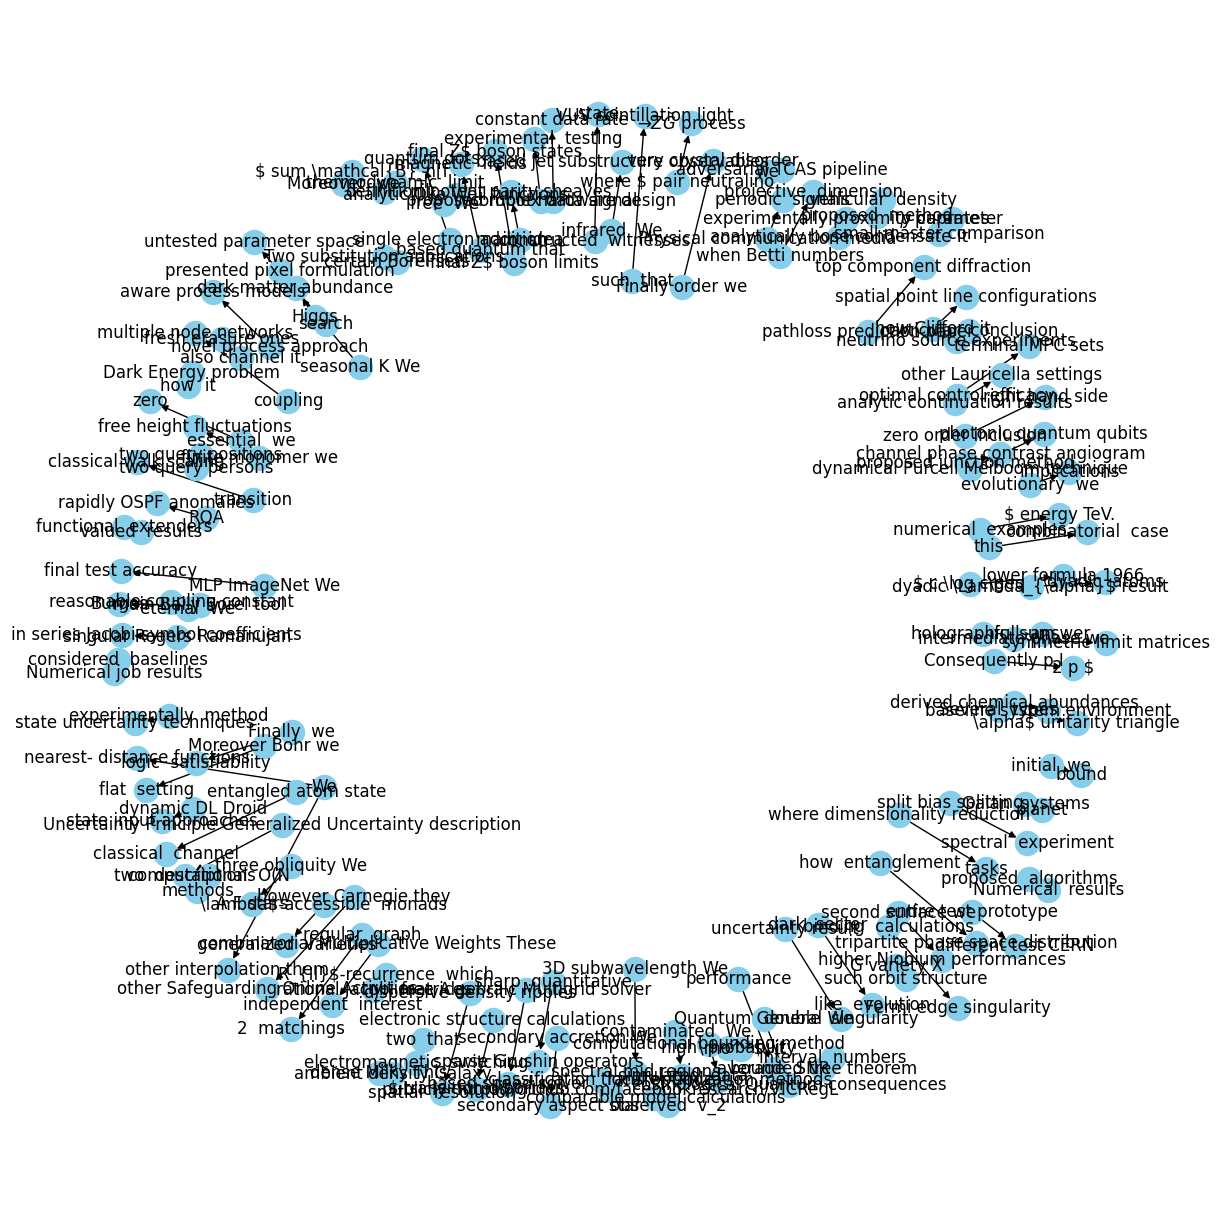

In [ ]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

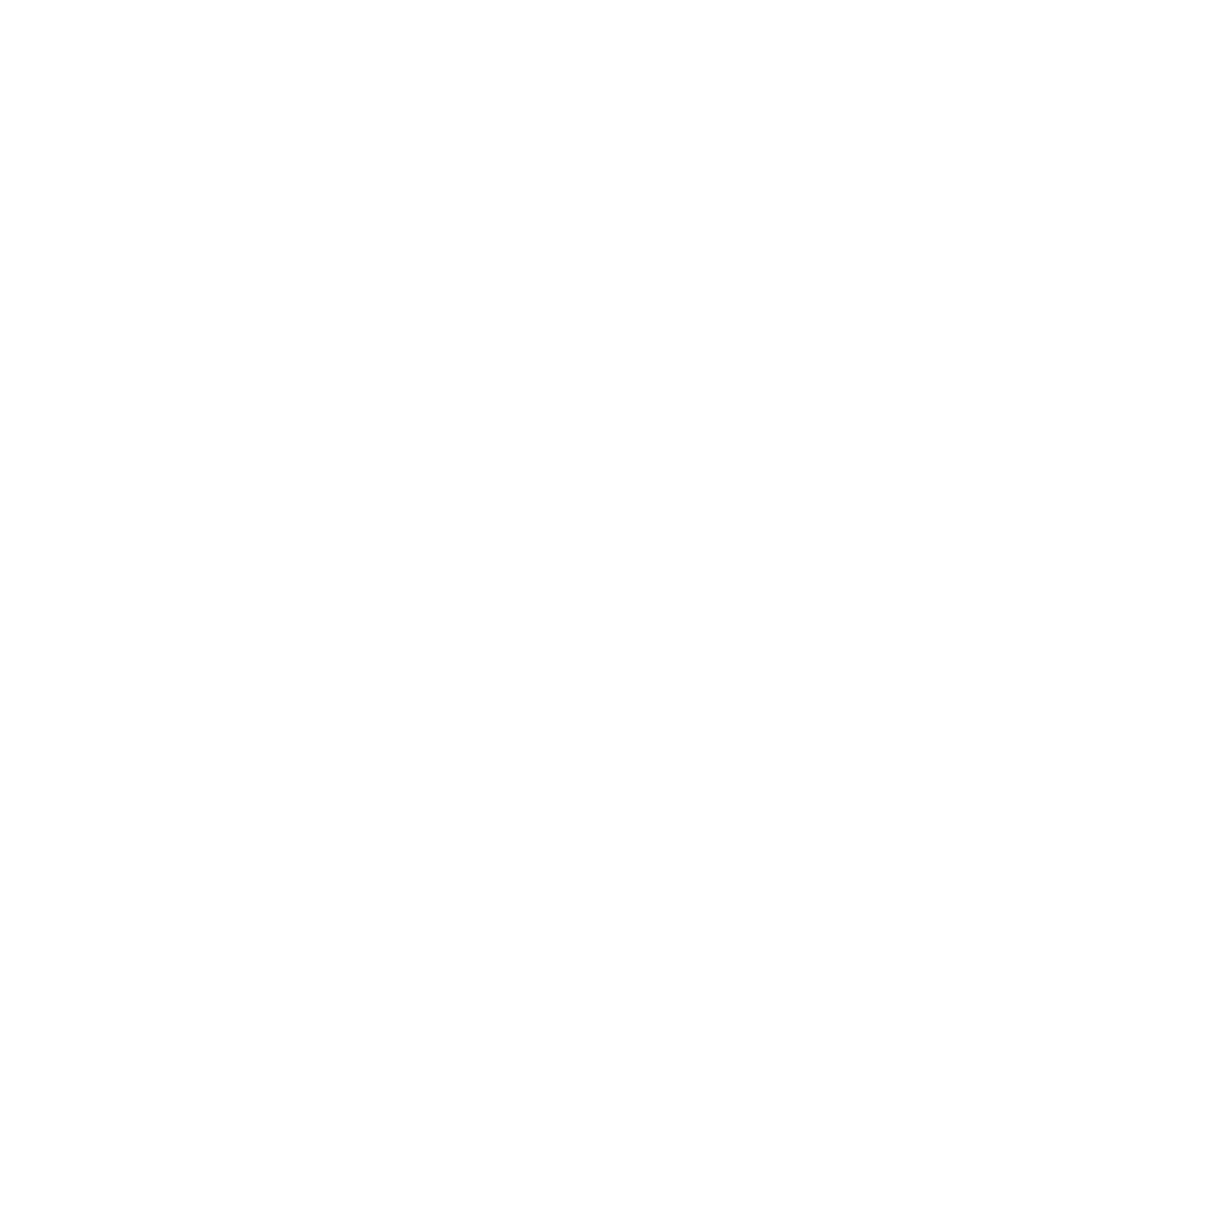

In [ ]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="used by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

### NLP pre-processing

### Regression model 

## Interface - liam